In [1]:
import pandas as pd
from sodapy import Socrata
import plotly.express as px
import nbformat
import matplotlib.pyplot as plt
from datetime import *
import statsmodels.api as sm
import seaborn as sns
import plotly.io as pio
import numpy as np
import plotly.graph_objects as go
import plotly.subplots as sp
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.impute import SimpleImputer
from statsmodels.tsa.api import SimpleExpSmoothing

In [2]:
# https://dev.socrata.com/foundry/data.cityofnewyork.us/k46n-sa2m
client = Socrata("data.cityofnewyork.us", None)
results = client.get("k46n-sa2m",limit=80000)

# Convert to pandas DataFrame
dhs_daily_df = pd.DataFrame.from_records(results)

In [3]:
# https://dev.socrata.com/foundry/data.cityofnewyork.us/6z8x-wfk4
client = Socrata("data.cityofnewyork.us", None)
results = client.get("6z8x-wfk4",limit=80000)

# Convert to pandas DataFrame
evictions_df = pd.DataFrame.from_records(results)

In [4]:
# https://dev.socrata.com/foundry/data.cityofnewyork.us/hebw-6hze

client = Socrata("data.cityofnewyork.us", None)
results = client.get("hebw-6hze",limit=80000)


# Convert to pandas DataFrame
demos_by_zip_df = pd.DataFrame.from_records(results)

In [5]:
#converting to type numeric
cols = dhs_daily_df.columns.drop('date_of_census')
dhs_daily_df[cols] = dhs_daily_df[cols].apply(pd.to_numeric)
dhs_daily_df['date_of_census'] = pd.to_datetime(dhs_daily_df['date_of_census'])

In [6]:
evictions_df['executed_date'] = pd.to_datetime(evictions_df['executed_date'])

In [7]:
#demos_by_zip_df.info()
demos_by_zip_df['data_os_of_date'] = pd.to_datetime(demos_by_zip_df['data_os_of_date'])


In [8]:

# Create a list to store the new column names
new_columns = []

# Iterate over each column
for column in dhs_daily_df.columns:
    if column != 'total_individuals_in_shelter' and column != 'date_of_census':
        # Generate the new column name with the prefix "perc_" followed by the original column name
        new_column = 'perc_' + column
        
        # Divide the values in the current column by the values in the 'total_individuals_in_shelter' column
        new_values = ((dhs_daily_df[column].astype(float) / dhs_daily_df['total_individuals_in_shelter'].astype(float))*100).round(2)
        
        # Append the new column to the DataFrame
        dhs_daily_df[new_column] = new_values
        
        # Append the new column name to the list
        new_columns.append(new_column)

In [9]:
# Set the 'date' column as the index
dhs_daily_df.set_index('date_of_census', inplace=True)

# Resample to monthly average data
monthly_avg_df = dhs_daily_df.resample('M').mean()

# Resample to quarterly average data
quarterly_avg_df = dhs_daily_df.resample('Q').mean()

# Resample to quarterly average data
yearly_avg_df = dhs_daily_df.resample('Y').mean()

In [10]:
counts_by_boro_piv = pd.pivot_table(evictions_df,values='docket_number', aggfunc='count',index='executed_date',columns='borough').reset_index().sort_values(by='executed_date',ascending=False)


In [11]:
# Convert 'executed_date' column to datetime
counts_by_boro_piv['executed_date'] = pd.to_datetime(counts_by_boro_piv['executed_date'])


In [12]:
# create new dataframe with eviction counts
evictions_counts_df = evictions_df.groupby('executed_date')['docket_number'].count().reset_index()

# Rename the count column to 'count_of_docket_numbers'
evictions_counts_df = evictions_counts_df.rename(columns={'docket_number': 'eviction_count'})

In [31]:
# Merge the two DataFrames based on the 'executed_date' column
merged_df = pd.merge(dhs_daily_df, evictions_counts_df, left_on='date_of_census', right_on='executed_date')

# Multiply 'eviction_count' by arbitrary number of 10 to normalize given the limitations of the dataset
merged_df['eviction_count'] = merged_df['eviction_count'] * 10


# Forecasting Models

### Simple Moving Average

In [35]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 25 columns):
 #   Column                                                        Non-Null Count  Dtype         
---  ------                                                        --------------  -----         
 0   total_adults_in_shelter                                       1255 non-null   int64         
 1   total_children_in_shelter                                     1255 non-null   int64         
 2   total_individuals_in_shelter                                  1255 non-null   int64         
 3   single_adult_men_in_shelter                                   1255 non-null   int64         
 4   single_adult_women_in_shelter                                 1255 non-null   int64         
 5   total_single_adults_in_shelter                                1255 non-null   int64         
 6   families_with_children_in_shelter                             1255 non-null   int64         
 7   adults

In [36]:
merged_df.set_index('executed_date', inplace=True)


In [68]:
window_size = 2
sma = merged_df['total_individuals_in_shelter'].rolling(window_size).mean()

In [75]:
window_size = 2
sma = merged_df['total_individuals_in_shelter'].rolling(window_size).mean().dropna()
actual_values = merged_df['total_individuals_in_shelter'][window_size-1:].reset_index(drop=True)

mse_sma = mean_squared_error(actual_values, sma)
mae_sma = mean_absolute_error(actual_values, sma)

print("Mean Squared Error (MSE):", mse_sma)
print("Mean Absolute Error (MAE):", mae_sma)

Mean Squared Error (MSE): 10833.90350877193
Mean Absolute Error (MAE): 59.2200956937799


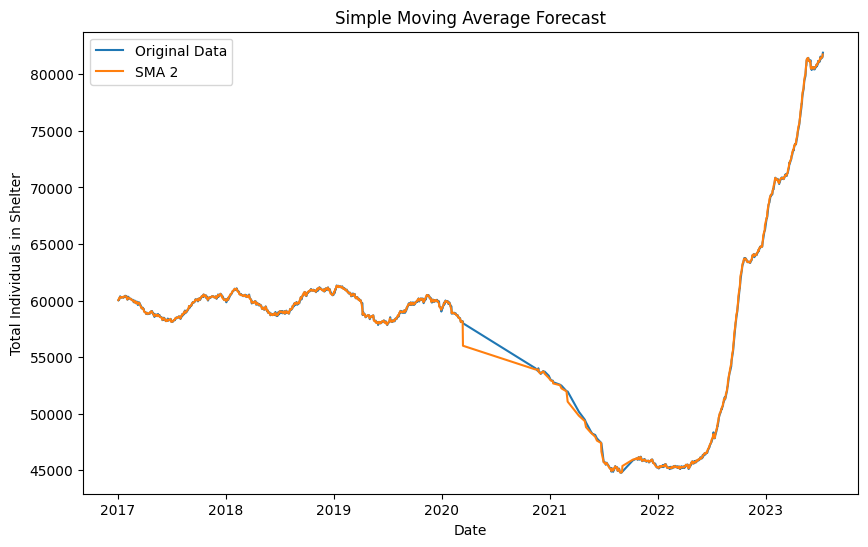

In [66]:
plt.figure(figsize=(10, 6))
plt.plot(merged_df.index, merged_df['total_individuals_in_shelter'], label='Original Data')
plt.plot(merged_df.index, sma, label=f'SMA {window_size}')
plt.xlabel('Date')
plt.ylabel('Total Individuals in Shelter')
plt.title('Simple Moving Average Forecast')
plt.legend()
plt.show()

### Exponential Smoothing

In [39]:

# Extract the column to forecast- 'total_individuals_in_shelter'
data = merged_df['total_individuals_in_shelter']


/Users/mofeoluwajide-jegede/ds4a-2023-team-7/ds-team-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mofeoluwajide-jegede/ds4a-2023-team-7/ds-team-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mofeoluwajide-jegede/ds4a-2023-team-7/ds-team-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/mofeoluwajide-jegede/ds4a-2023-team-7/ds-team-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supporte

Mean Squared Error (MSE): 67238314.6097581
Mean Absolute Error (MAE): 7299.916162758659


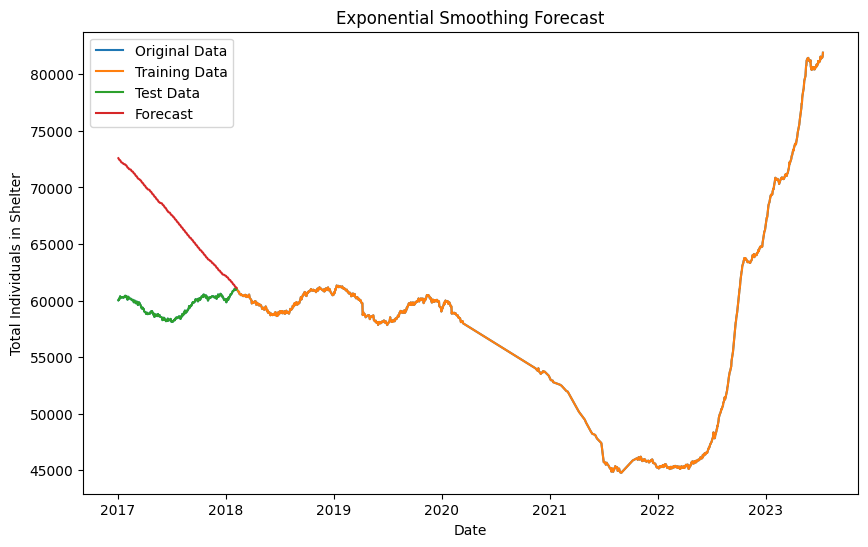

In [76]:

# Split the data into training and testing sets (e.g., 80% for training, 20% for testing)
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]
# Create the ExponentialSmoothing model and fit it to the training data
model = ExponentialSmoothing(train_data, trend='add', seasonal=None)
model_fit = model.fit()

# Perform forecasting on the test data
forecast = model_fit.forecast(len(test_data))

# Calculate MSE and MAE
mse_exp = mean_squared_error(test_data, forecast)
mae_exp = mean_absolute_error(test_data, forecast)

print("Mean Squared Error (MSE):", mse_exp)
print("Mean Absolute Error (MAE):", mae_exp)

# Plot the original data, training data, and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(data.index, data, label='Original Data')
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Test Data')
plt.plot(test_data.index, forecast, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Total Individuals in Shelter')
plt.title('Exponential Smoothing Forecast')
plt.legend()
plt.show()

### Seasonal Naive Model

Mean Squared Error (MSE): 2412641.915683108
Mean Absolute Error (MAE): 1321.3014882970044


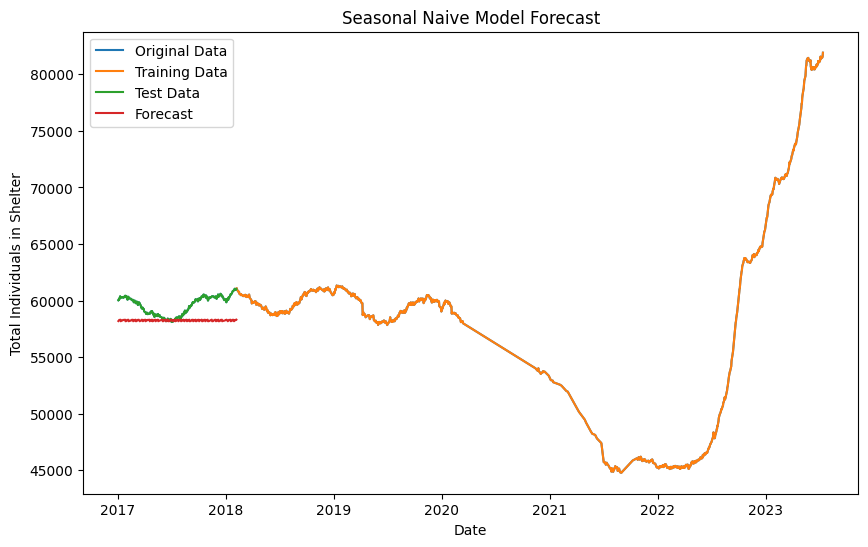

In [77]:

# Split the data into training and testing sets (e.g., 80% for training, 20% for testing)
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# Determine the seasonal period (e.g., 7 for weekly data, 12 for monthly data)
seasonal_period = 7

# Create an array to store the seasonal averages for each period
seasonal_averages = np.zeros(seasonal_period)

# Calculate the seasonal averages for each period
for i in range(seasonal_period):
    seasonal_averages[i] = train_data[i::seasonal_period].mean()

# Create an array to store the forecasted values
forecast = np.zeros(len(test_data))

# Perform forecasting using the seasonal averages
for i in range(len(test_data)):
    forecast[i] = seasonal_averages[i % seasonal_period]


# Calculate MSE and MAE
mse_snm = mean_squared_error(test_data, forecast)
mae_snm = mean_absolute_error(test_data, forecast)

print("Mean Squared Error (MSE):", mse_snm)
print("Mean Absolute Error (MAE):", mae_snm)


# Plot the original data, training data, and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(data.index, data, label='Original Data')
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Test Data')
plt.plot(test_data.index, forecast, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Total Individuals in Shelter')
plt.title('Seasonal Naive Model Forecast')
plt.legend()
plt.show()


### ARIMA Model

/Users/mofeoluwajide-jegede/ds4a-2023-team-7/ds-team-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mofeoluwajide-jegede/ds4a-2023-team-7/ds-team-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mofeoluwajide-jegede/ds4a-2023-team-7/ds-team-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mofeoluwajide-jegede/ds4a-2023-team-7/ds-team-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarni

Evaluation Metrics for ARIMA:
ARIMA - MAE:  2316.1648792571045
ARIMA - RMSE:  2505.39457699964


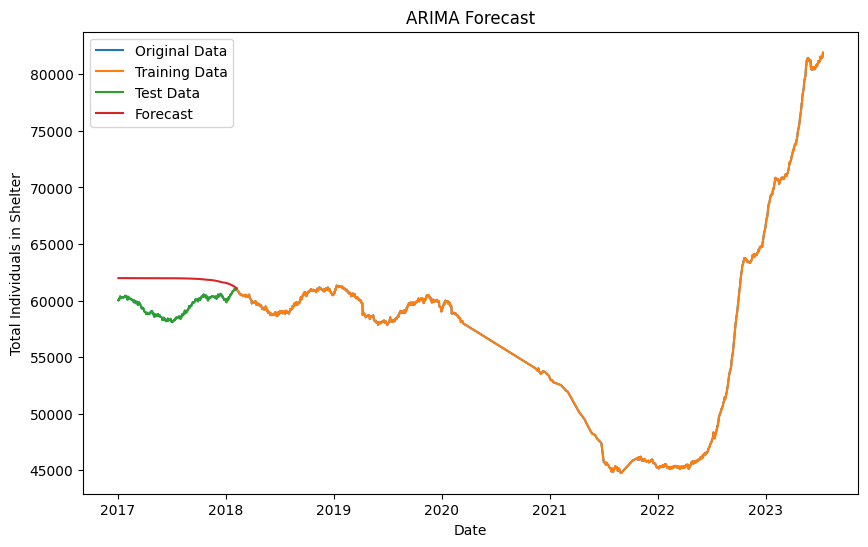

In [78]:
# Split the data into training and testing sets (e.g., 80% for training, 20% for testing)
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# Create an ARIMA model with the appropriate order (p, d, q) values
# For example, (1, 1, 1) indicates one autoregressive term, one differencing term, and one moving average term
model = ARIMA(train_data, order=(1, 1, 1))

# Fit the ARIMA model to the training data
model_fit = model.fit()

# Perform forecasting on the test data
forecast_arima = model_fit.forecast(steps=len(test_data))

# Calculate MAE and RMSE for ARIMA model
mae_arima = mean_absolute_error(test_data, forecast_arima)
mse_arima = mean_squared_error(test_data, forecast_arima)

# Calculate MAE and RMSE for other models (e.g., Seasonal Naive Model)

# ... Code for other models

# Print evaluation metrics for all models
print("Evaluation Metrics for ARIMA:")
print("ARIMA - MAE: ", mae_arima)
print("ARIMA - RMSE: ", rmse_arima)
# Plot the original data, training data, and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(data.index, data, label='Original Data')
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Test Data')
plt.plot(test_data.index, forecast_arima, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Total Individuals in Shelter')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

In [79]:

# # Define the models
# window_size = 10  # For simple moving average
# seasonal_period = 12  # For seasonal naive model
# simple_moving_average = merged_df['total_individuals_in_shelter'].rolling(window_size).mean()
# exponential_smoothing = SimpleExpSmoothing(merged_df['total_individuals_in_shelter']).fit().fittedvalues
# seasonal_naive = merged_df['total_individuals_in_shelter'].shift(seasonal_period)
# arima_model = ARIMA(merged_df['total_individuals_in_shelter'], order=(1, 0, 0)).fit()

# # Calculate evaluation metrics
# smoothing_mse = mean_squared_error(merged_df['total_individuals_in_shelter'], exponential_smoothing)
# smoothing_mae = mean_absolute_error(merged_df['total_individuals_in_shelter'], exponential_smoothing)
# moving_average_mse = mean_squared_error(merged_df['total_individuals_in_shelter'].iloc[window_size-1:], simple_moving_average.dropna())
# moving_average_mae = mean_absolute_error(merged_df['total_individuals_in_shelter'].iloc[window_size-1:], simple_moving_average.dropna())
# seasonal_naive_mse = mean_squared_error(merged_df['total_individuals_in_shelter'].iloc[seasonal_period:], seasonal_naive.dropna())
# seasonal_naive_mae = mean_absolute_error(merged_df['total_individuals_in_shelter'].iloc[seasonal_period:], seasonal_naive.dropna())
# arima_mse = mean_squared_error(merged_df['total_individuals_in_shelter'], arima_model.fittedvalues)
# arima_mae = mean_absolute_error(merged_df['total_individuals_in_shelter'], arima_model.fittedvalues)

# Print the metrics
print("Evaluation Metrics:")
print("Exponential Smoothing - MSE:", mse_exp)
print("Exponential Smoothing - MAE:", mae_exp)
print("Simple Moving Average - MSE:", mse_sma)
print("Simple Moving Average - MAE:", mae_sma)
print("Seasonal Naive - MSE:", mse_snm)
print("Seasonal Naive - MAE:", mae_snm)
print("ARIMA - MSE:", mse_arima)
print("ARIMA - MAE:", mae_arima)


Evaluation Metrics:
Exponential Smoothing - MSE: 67238314.6097581
Exponential Smoothing - MAE: 7299.916162758659
Simple Moving Average - MSE: 10833.90350877193
Simple Moving Average - MAE: 59.2200956937799
Seasonal Naive - MSE: 2412641.915683108
Seasonal Naive - MAE: 1321.3014882970044
ARIMA - MSE: 6277001.986459204
ARIMA - MAE: 2316.1648792571045


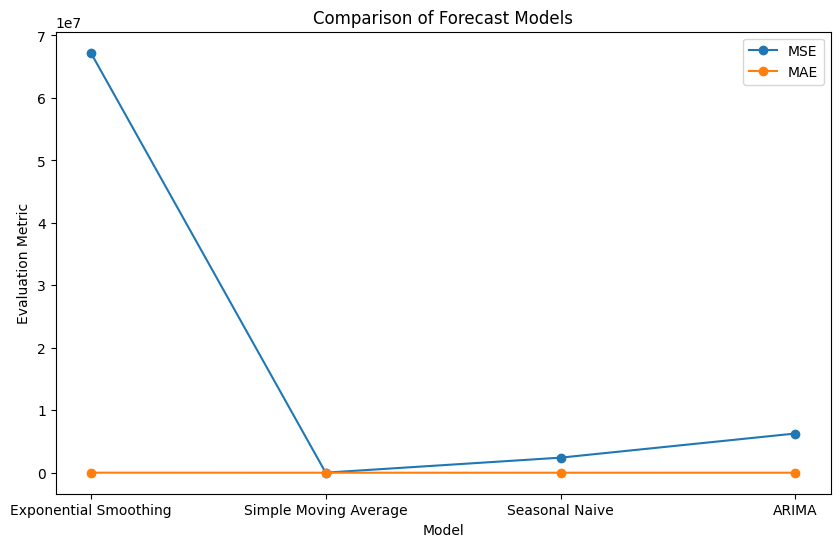

In [80]:
# Evaluation metrics
metrics = {
    'Exponential Smoothing': [mse_exp, mae_exp],
    'Simple Moving Average': [mse_sma, mae_sma],
    'Seasonal Naive': [mse_snm, mae_snm],
    'ARIMA': [mse_arima, mae_arima]
}

# Prepare data for plotting
model_names = list(metrics.keys())
mse_values = [metric[0] for metric in metrics.values()]
mae_values = [metric[1] for metric in metrics.values()]

# Set the figure size
plt.figure(figsize=(10, 6))

# Create a line chart for MSE
plt.plot(model_names, mse_values, marker='o', label='MSE')

# Create a line chart for MAE
plt.plot(model_names, mae_values, marker='o', label='MAE')

# Set x-axis label
plt.xlabel('Model')

# Set y-axis label
plt.ylabel('Evaluation Metric')

# Set title
plt.title('Comparison of Forecast Models')

# Add legend
plt.legend()

# Display the plot
plt.show()


### XGBoost Model

In [53]:
# Merge the two DataFrames based on the 'executed_date' column
data = pd.merge(dhs_daily_df, evictions_counts_df, left_on='date_of_census', right_on='executed_date')

In [55]:
# Extract relevant date features
data['year'] = data['executed_date'].dt.year
data['month'] = data['executed_date'].dt.month
data['day'] = data['executed_date'].dt.day
data['day_of_week'] = data['executed_date'].dt.dayofweek

In [74]:
# Define the features to drop
features_to_drop = [
    'total_individuals_in_shelter', 'total_adults_in_shelter', 'total_children_in_shelter',
    'single_adult_men_in_shelter', 'single_adult_women_in_shelter', 'total_single_adults_in_shelter',
    'families_with_children_in_shelter', 'adults_in_families_with_children_in_shelter',
    'children_in_families_with_children_in_shelter',
    'total_individuals_in_families_with_children_in_shelter_',
    'adult_families_in_shelter', 'individuals_in_adult_families_in_shelter',
    'perc_total_adults_in_shelter', 'perc_total_children_in_shelter',
    'perc_single_adult_men_in_shelter', 'perc_single_adult_women_in_shelter',
    'perc_total_single_adults_in_shelter', 'perc_families_with_children_in_shelter',
    'perc_adults_in_families_with_children_in_shelter',
    'perc_children_in_families_with_children_in_shelter',
    'perc_total_individuals_in_families_with_children_in_shelter_',
    'perc_adult_families_in_shelter', 'perc_individuals_in_adult_families_in_shelter', 'executed_date', 'eviction_count'
]

In [75]:
# Split the data into features (X) and target variable (y)
X = data.drop(features_to_drop, axis=1)
y = data[['total_individuals_in_shelter', 'total_adults_in_shelter', 'total_children_in_shelter', 'eviction_count']]


In [87]:

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the XGBoost model
model = xgb.XGBRegressor()


In [90]:
# Define the hyperparameters to tune and their potential values
param_grid = {
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

In [93]:

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the model with the best hyperparameters
model = xgb.XGBRegressor(**best_params)

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}


In [94]:
# Train the model
model.fit(X_train, y_train)

# Make forecasts on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 16084.960473730745


In [95]:
future_features = pd.DataFrame({
    'year': [future_date.year],
    'month': [future_date.month],
    'day': [future_date.day],
    'day_of_week': [future_date.dayofweek]
})

In [96]:
# Forecast future values
future_date = pd.to_datetime('2023-07-15')  # Replace with the relevant future date
#future_features = future_date.year, future_date.month, future_date.day, future_date.dayofweek
future_forecast = model.predict(future_features)
print("Future Forecast:", future_forecast)

Future Forecast: [[8.1829906e+04 5.3536461e+04 2.8185928e+04 1.9747210e+01]]
